In [1]:
pip install -U imbalanced-learn

  Using cached imbalanced_learn-0.8.1-py3-none-any.whl (189 kB)
  Using cached scikit_learn-1.0.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (23.2 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install xgboost

  Using cached xgboost-1.5.1-py3-none-manylinux2014_x86_64.whl (173.5 MB)


In [3]:
pip install -U prettytable

  Using cached prettytable-2.4.0-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt       
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report,roc_auc_score,plot_confusion_matrix,cohen_kappa_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from statistics import mean, stdev
#from sklearn import linear_model
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from prettytable import PrettyTable 
import time


In [5]:
# Import clean dataset
df = pd.read_csv('/home/jovyan/CTG_clean.csv')
df

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,240.0,0.0,240.0,17.0,2.1,0.0,10.4,120.0,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,120.0,0.0,300.0,16.0,2.1,0.0,13.4,120.0,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,120.0,0.0,360.0,16.0,2.4,0.0,23.0,120.0,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,240.0,0.0,300.0,16.0,2.4,0.0,19.9,0.0,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.0,0.0,360.0,79.0,0.2,25.0,7.2,0.0,0.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,60.0,0.0,540.0,78.0,0.4,22.0,7.1,0.0,0.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,60.0,0.0,420.0,79.0,0.4,20.0,6.1,0.0,0.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,60.0,0.0,540.0,78.0,0.4,27.0,7.0,0.0,0.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [6]:
x = df.drop(['NSP'],axis=1).values     # features
y = df['NSP'].values                   # classes

Text(0.5, 1.0, 'Class Frequency in Original Dataset Histogram')

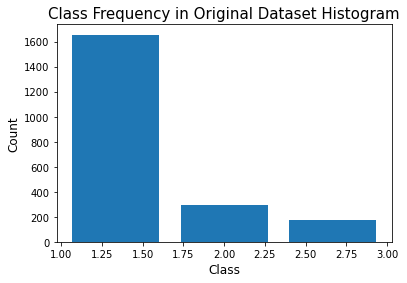

In [7]:
# Plot class frequency in imbalanced train set
plt.hist(y, bins=3, rwidth=0.8)
plt.xlabel('Class',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Class Frequency in Original Dataset Histogram',fontsize=15)

In [8]:
# XGBoost classifier requires the classes to take integer values starting from 0.
# Chang data type of the values in array y from float to integers. 
y = y.astype(int)
print(y.dtype)              # check data type of y
y_classes = list(set(y))    # check classes labels in y
y_classes

int64


[1, 2, 3]

In [9]:
# Use LabelEncoder to transform classes to 0,1,2.
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)       # encode labels in y 
y_classes = list(set(y))                 # check the new classes labels
y_classes

[0, 1, 2]

# K-Fold Cross Validation

Next, the algorithms will be applied using K-Fold Cross Validation and Smote-NC to balance the train dataset in each iteration.
Smote-NC will be applied as it provides better results for datasets that contains categorial variables. 
In the CTG dataset, the 'Tendency' feature (index = 20 in the dataset) is categorical, which has three possible values (0, 1 and 2). 

In [10]:
# Create KFold object with K=10 and Suffle to shuffle data before splitting.
kf = KFold(n_splits=10, shuffle = True, random_state=11)

### Random Forest (K-Fold Cross Validation)

In [11]:
# Create classifier object
forest = RandomForestClassifier(random_state=11)

# Create list to store performance metrics
accuracy_forest = []
precision_forest = []
recall_forest = []
f1_forest = []
rocauc_forest = []
kappa_forest = []
matthews_forest = []
time_forest = []


# Apply K-Fold Cross Validation 
# for each iteration:
n=0
for train_index, test_index in kf.split(x, y): 
    # start measuring processing time
    start_fold = time.time() 
    
    # split dataset into training and test sets.
    x_train_fold, x_test_fold = x[train_index], x[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # create augmentation object, where attribute with index 20 is categorical.
    smote_nc = SMOTENC(categorical_features=[20])     
    # apply SmoteNC to x_train and y_train
    x_train_sm, y_train_sm = smote_nc.fit_resample(x_train_fold, y_train_fold)
  
    # fit the model to x_train_sm and y_train_sm
    forest.fit(x_train_fold, y_train_fold)
    # predict classes for x_test_fold
    y_pred_fold = forest.predict(x_test_fold)
    
    # calculate performance metrics
    accuracy =       accuracy_score(y_test_fold,y_pred_fold)
    precision =      precision_score(y_test_fold,y_pred_fold, average='weighted',zero_division=0)   
    recall =         recall_score(y_test_fold,y_pred_fold, average='weighted', zero_division=0)
    f1 =             f1_score(y_test_fold,y_pred_fold, average='weighted')
    rocauc =         roc_auc_score(y_test_fold,forest.predict_proba(x_test_fold), average='weighted', multi_class='ovo', max_fpr=None)
    kappa =          cohen_kappa_score(y_test_fold,y_pred_fold,weights='quadratic')
    matthews =       matthews_corrcoef(y_test_fold,y_pred_fold)
    
    # add metric scores to corresponding list
    accuracy_forest.append(accuracy)
    precision_forest.append(precision)
    recall_forest.append(recall)
    f1_forest.append(f1)
    rocauc_forest.append(rocauc)
    kappa_forest.append(kappa)
    matthews_forest.append(matthews)
    
    # finish measuring processing time
    end_fold = time.time() 
    # calculate total processing time
    time_fold = end_fold - start_fold
    # add processing time to time list
    time_forest.append(time_fold)   

    n+=1
    

# Calculate average of performance metrics of 10 folds.
average_accuracy_forest = round(np.mean(accuracy_forest),3)
average_precision_forest = round(np.mean(precision_forest),3)
average_recall_forest =round(np.mean(recall_forest),3)
average_f1_forest = round(np.mean(f1_forest),3)
average_rocauc_forest = round(np.mean(rocauc_forest),3)
average_kappa_forest =round(np.mean(kappa_forest),3)
average_matthews_forest =round(np.mean(matthews_forest),3)
stdv_forest = np.round(stdev(accuracy_forest),4)
average_time_forest = round(np.mean(time_forest),1)


# Print metrics.
print('List of accuracy score for each fold:', accuracy_forest)
print('\nMaximum Accuracy:', np.round(max(accuracy_forest)*100,2),'%')
print('Minimum Accuracy:', np.round(min(accuracy_forest)*100,2),'%')

print('\nAverage Accuracy:', average_accuracy_forest)
print('Average Precision:', average_precision_forest)
print('Average Recall:', average_recall_forest)
print('Average F-1 Score:', average_f1_forest)
print('Average ROC-AUC:', average_rocauc_forest)
print('Avergae Cohen Kappa', average_kappa_forest)
print("Avergae Matthew's Correlation Coef.", average_matthews_forest)
print('Standard Deviation:', stdv_forest)
print('Average processing time:', average_time_forest)

List of accuracy score for each fold: [0.9483568075117371, 0.9530516431924883, 0.9530516431924883, 0.9483568075117371, 0.9436619718309859, 0.9483568075117371, 0.9386792452830188, 0.9339622641509434, 0.9386792452830188, 0.9575471698113207]

Maximum Accuracy: 95.75 %
Minimum Accuracy: 93.4 %

Average Accuracy: 0.946
Average Precision: 0.946
Average Recall: 0.946
Average F-1 Score: 0.945
Average ROC-AUC: 0.988
Avergae Cohen Kappa 0.896
Avergae Matthew's Correlation Coef. 0.852
Standard Deviation: 0.0075
Average processing time: 0.5


### XGBoost (K-Fold Cross Validation)

In [12]:
# Create classifier object.
xgb = XGBClassifier(learning_rate=0.001,use_label_encoder=False, objective = "multi:softprob", eval_metric='mlogloss') 

# Create list to store performance metrics
accuracy_xgb = []
accuracy_xgb = []
precision_xgb = []
recall_xgb = []
f1_xgb = []
rocauc_xgb = []
kappa_xgb = []
matthews_xgb = []
time_xgb = []


# Apply K-Fold Cross Validation 
# for each iteration:
n=0
for train_index, test_index in kf.split(x, y):
    # start measuring processing time
    start_fold = time.time() 
    
    # split dataset into training and test sets.
    x_train_fold, x_test_fold = x[train_index], x[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # create augmentation object, where attribute with index 20 is categorical.
    smote_nc = SMOTENC(categorical_features=[20])
    # apply SmoteNC to x_train and y_train
    x_train_sm, y_train_sm = smote_nc.fit_resample(x_train_fold, y_train_fold)
  
    # fit the model to x_train_sm and y_train_sm
    xgb.fit(x_train_sm, y_train_sm)
    # predict classes for x_test_fold
    y_pred_fold = xgb.predict(x_test_fold)
    
    # calculate performance metrics
    accuracy =       accuracy_score(y_test_fold,y_pred_fold)
    precision =      precision_score(y_test_fold,y_pred_fold, average='weighted',zero_division=0)
    recall =         recall_score(y_test_fold,y_pred_fold, average='weighted', zero_division=0)
    f1 =             f1_score(y_test_fold,y_pred_fold, average='weighted')
    rocauc =         roc_auc_score(y_test_fold,xgb.predict_proba(x_test_fold), average='weighted', multi_class='ovo', max_fpr=None)
    kappa =          cohen_kappa_score(y_test_fold,y_pred_fold,weights='quadratic')
    matthews =       matthews_corrcoef(y_test_fold,y_pred_fold)
    
    # add metric scores to corresponding list
    accuracy_xgb.append(accuracy)
    precision_xgb.append(precision)
    recall_xgb.append(recall)
    f1_xgb.append(f1)
    rocauc_xgb.append(rocauc)
    kappa_xgb.append(kappa)
    matthews_xgb.append(matthews)
    
    # finish measuring processing time
    end_fold = time.time() 
    # calculate total processing time
    time_fold = end_fold - start_fold
    # add processing time to time list
    time_xgb.append(time_fold)  

    n+=1


# Calculate average of performance metrics of 10 folds.
average_accuracy_xgb = round(np.mean(accuracy_xgb),3)
average_precision_xgb = round(np.mean(precision_xgb),3)
average_recall_xgb =round(np.mean(recall_xgb),3)
average_f1_xgb = round(np.mean(f1_xgb),3)
average_rocauc_xgb = round(np.mean(rocauc_xgb),3)
average_kappa_xgb =round(np.mean(kappa_xgb),3)
average_matthews_xgb =round(np.mean(matthews_xgb),3)
stdv_xgb = np.round(stdev(accuracy_xgb),4)
average_time_xgb = round(np.mean(time_xgb),1)


# Print metrics.
print('List of accuracy score for each fold:', accuracy_xgb)
print('\nMaximum Accuracy:', np.round(max(accuracy_xgb)*100,2),'%')
print('Minimum Accuracy:', np.round(min(accuracy_xgb)*100,2),'%')

print('\nAverage Accuracy:', average_accuracy_xgb)
print('Average Precision:', average_precision_xgb)
print('Average Recall:', average_recall_xgb)
print('Average F-1 Score:', average_f1_xgb)
print('Average ROC-AUC:', average_rocauc_xgb)
print('Avergae Cohen Kappa', average_kappa_xgb)
print("Avergae Matthew's Correlation Coef.", average_matthews_xgb)
print('Standard Deviation:', stdv_xgb)
print('Average processing time:', average_time_xgb)

List of accuracy score for each fold: [0.9107981220657277, 0.8732394366197183, 0.8779342723004695, 0.9436619718309859, 0.8779342723004695, 0.9248826291079812, 0.8820754716981132, 0.9198113207547169, 0.9245283018867925, 0.9481132075471698]

Maximum Accuracy: 94.81 %
Minimum Accuracy: 87.32 %

Average Accuracy: 0.908
Average Precision: 0.924
Average Recall: 0.908
Average F-1 Score: 0.913
Average ROC-AUC: 0.971
Avergae Cohen Kappa 0.83
Avergae Matthew's Correlation Coef. 0.779
Standard Deviation: 0.0284
Average processing time: 2.3


### MLP (Scaling &  K-Fold Cross Validation)

In [13]:
# MLP classifier requires the dataset to be scaled. 
scaler = preprocessing.StandardScaler()      # Create Scaling object
x_scaled = scaler.fit_transform(x)           # Scale x (features) to apply MLP

In [14]:
# Create classifier object.
mlp = MLPClassifier(max_iter = 800)

# Create list to store performance metrics
accuracy_mlp = []
precision_mlp = []
recall_mlp = []
f1_mlp = []
rocauc_mlp = []
kappa_mlp = []
matthews_mlp = []
time_mlp = []

# Apply K-Fold Cross Validation 
# for each iteration:
n=0
for train_index, test_index in kf.split(x_scaled, y):
    # start measuring processing time
    start_fold = time.time() 

    # split dataset into training and test sets. X in this case is x_scaled.
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # create augmentation object, where attribute with index 20 is categorical.
    smote_nc = SMOTENC(categorical_features=[20])
    # apply SmoteNC to x_train and y_train
    x_train_sm, y_train_sm = smote_nc.fit_resample(x_train_fold, y_train_fold)
  
    # fit the model to x_train_sm and y_train_sm
    mlp.fit(x_train_sm, y_train_sm)
    # predict classes for x_test_fold
    y_pred_fold = mlp.predict(x_test_fold)
    
    # calculate performance metrics
    accuracy =       accuracy_score(y_test_fold,y_pred_fold)
    precision =      precision_score(y_test_fold,y_pred_fold, average='weighted',zero_division=0)
    recall =         recall_score(y_test_fold,y_pred_fold, average='weighted', zero_division=0)
    f1 =             f1_score(y_test_fold,y_pred_fold, average='weighted')
    rocauc =         roc_auc_score(y_test_fold,mlp.predict_proba(x_test_fold), average='weighted', multi_class='ovo', max_fpr=None)
    kappa =          cohen_kappa_score(y_test_fold,y_pred_fold,weights='quadratic')
    matthews =       matthews_corrcoef(y_test_fold,y_pred_fold)
    
    # add metric scores to corresponding list
    accuracy_mlp.append(accuracy)
    precision_mlp.append(precision)
    recall_mlp.append(recall)
    f1_mlp.append(f1)
    rocauc_mlp.append(rocauc)
    kappa_mlp.append(kappa)
    matthews_mlp.append(matthews)

    # finish measuring processing time
    end_fold = time.time() 
    # calculate total processing time
    time_fold = end_fold - start_fold
    # add processing time to time list
    time_mlp.append(time_fold)
    
    n+=1


# Calculate average of performance metrics of 10 folds.
average_accuracy_mlp = round(np.mean(accuracy_mlp),3)
average_precision_mlp = round(np.mean(precision_mlp),3)
average_recall_mlp =round(np.mean(recall_mlp),3)
average_f1_mlp = round(np.mean(f1_mlp),3)
average_rocauc_mlp = round(np.mean(rocauc_mlp),3)
average_kappa_mlp =round(np.mean(kappa_mlp),3)
average_matthews_mlp =round(np.mean(matthews_mlp),3)
stdv_mlp = np.round(stdev(accuracy_mlp),4)
average_time_mlp = round(np.mean(time_mlp),1)
    
# Print metrics.
print('List of accuracy score for each fold:', accuracy_mlp)
print('\nMaximum Accuracy:', np.round(max(accuracy_mlp)*100,2),'%')
print('Minimum Accuracy:', np.round(min(accuracy_mlp)*100,2),'%')

print('\nAverage Accuracy:', average_accuracy_mlp)
print('Average Precision:', average_precision_mlp)
print('Average Recall:', average_recall_mlp)
print('Average F-1 Score:', average_f1_mlp)
print('Average ROC-AUC:', average_rocauc_mlp)
print('Avergae Cohen Kappa', average_kappa_mlp)
print("Avergae Matthew's Correlation Coef.", average_matthews_mlp)
print('Standard Deviation:', stdv_mlp)
print('Average processing time:', average_time_mlp)

List of accuracy score for each fold: [0.9436619718309859, 0.9389671361502347, 0.9295774647887324, 0.9389671361502347, 0.9577464788732394, 0.9483568075117371, 0.9198113207547169, 0.9150943396226415, 0.9386792452830188, 0.9433962264150944]

Maximum Accuracy: 95.77 %
Minimum Accuracy: 91.51 %

Average Accuracy: 0.937
Average Precision: 0.94
Average Recall: 0.937
Average F-1 Score: 0.938
Average ROC-AUC: 0.98
Avergae Cohen Kappa 0.885
Avergae Matthew's Correlation Coef. 0.833
Standard Deviation: 0.0128
Average processing time: 18.0


## Comparing Algorithms Performances

In [15]:
# Define table's column's names.
Performance_Metrics = PrettyTable(["Metric", "Random Forest", "XGBoost", "MLP"]) 
  
# Add rows to the table
Performance_Metrics.add_row(["Accuracy",     average_accuracy_forest,         average_accuracy_xgb,  average_accuracy_mlp]) 
Performance_Metrics.add_row(["Precision",    average_precision_forest,        average_precision_xgb, average_precision_mlp]) 
Performance_Metrics.add_row(["Recall",       average_recall_forest,           average_recall_xgb,    average_recall_mlp]) 
Performance_Metrics.add_row(["F-1 Score",    average_f1_forest,               average_f1_xgb,        average_f1_mlp])
Performance_Metrics.add_row(["ROC-AUC",      average_rocauc_forest,           average_rocauc_xgb,    average_rocauc_mlp])
Performance_Metrics.add_row(["Cohen's Kappa", average_kappa_forest,           average_kappa_xgb,     average_kappa_mlp])
Performance_Metrics.add_row(["Matthew's Corr. Coef.", average_matthews_forest,average_matthews_xgb,  average_matthews_mlp])
Performance_Metrics.add_row(["Accuracy St.Dv",stdv_forest,                    stdv_xgb,              stdv_mlp]) 
Performance_Metrics.add_row(["Average Time",average_time_forest,             average_time_xgb,      average_time_mlp]) 


print('Average Performance Metrics of Models Generated with K-Fold Cross Validation')
print(Performance_Metrics)

Average Performance Metrics of Models Generated with K-Fold Cross Validation
+-----------------------+---------------+---------+--------+
|         Metric        | Random Forest | XGBoost |  MLP   |
+-----------------------+---------------+---------+--------+
|        Accuracy       |     0.946     |  0.908  | 0.937  |
|       Precision       |     0.946     |  0.924  |  0.94  |
|         Recall        |     0.946     |  0.908  | 0.937  |
|       F-1 Score       |     0.945     |  0.913  | 0.938  |
|        ROC-AUC        |     0.988     |  0.971  |  0.98  |
|     Cohen's Kappa     |     0.896     |   0.83  | 0.885  |
| Matthew's Corr. Coef. |     0.852     |  0.779  | 0.833  |
|     Accuracy St.Dv    |     0.0075    |  0.0284 | 0.0128 |
|      Average Time     |      0.5      |   2.3   |  18.0  |
+-----------------------+---------------+---------+--------+
